In [1]:
import numpy as np
from datetime import datetime
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

plt.style.use('ggplot')
pl.Config.set_tbl_rows(50)
warnings.filterwarnings('ignore')

In [2]:
df = pl.read_csv('data/311_Service_Requests_from_2010_to_Present.csv', ignore_errors=True)

In [3]:
df = df.with_columns([
    pl.col('Created Date').str.to_datetime(format="%m/%d/%Y %I:%M:%S %p"),
    pl.col('Closed Date').str.to_datetime(format="%m/%d/%Y %I:%M:%S %p"),
    pl.col('Due Date').str.to_datetime(format="%m/%d/%Y %I:%M:%S %p"),
    pl.col('Resolution Action Updated Date').str.to_datetime(format="%m/%d/%Y %I:%M:%S %p"),
    ])

In [4]:
df.null_count().transpose(include_header=True).rename({'column': 'Column', 'column_0': 'Null Count'})

Column,Null Count
str,u32
"""Unique Key""",0
"""Created Date""",0
"""Closed Date""",163693
"""Agency""",0
"""Agency Name""",0
"""Complaint Type…",0
"""Descriptor""",30750
"""Location Type""",256708
"""Incident Zip""",27020


In [5]:
df = df.with_columns((pl.col('Closed Date') - pl.col('Created Date')).alias('Request Closing Time'))

In [6]:
df.head()

Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Description,Resolution Action Updated Date,Community Board,BBL,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Open Data Channel Type,Park Facility Name,Park Borough,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Latitude,Longitude,Location,Zip Codes,Community Districts,Borough Boundaries,City Council Districts,Police Precincts,Request Closing Time
i64,datetime[μs],datetime[μs],str,str,str,str,str,i64,str,str,str,str,str,str,str,str,str,str,str,datetime[μs],str,datetime[μs],str,i64,str,i64,i64,str,str,str,str,str,str,str,str,str,str,f64,f64,str,i64,i64,i64,i64,i64,duration[μs]
59348005,2023-11-07 12:00:00,null,"""DSNY""","""Department of …","""Derelict Vehic…","""Derelict Vehic…","""Street""",11212,"""585 BRISTOL ST…","""BRISTOL STREET…","""LOTT AVENUE""","""HEGEMAN AVENUE…",null,null,"""ADDRESS""","""BROOKLYN""",null,"""DSNY Garage""","""Open""",null,"""If the abandon…",2023-11-07 12:00:00,"""16 BROOKLYN""",3036240014,"""BROOKLYN""",1009407,178525,"""PHONE""","""Unspecified""","""BROOKLYN""",null,null,null,null,null,null,null,40.656651,-73.909331,"""(40.6566508445…",17614,55,2,25,46,null
59348006,2023-11-07 12:00:00,null,"""DSNY""","""Department of …","""Derelict Vehic…","""Derelict Vehic…","""Street""",11229,"""2362 EAST 13…","""EAST 13 STRE…","""GRAVESEND NECK…","""AVENUE X""",null,null,"""ADDRESS""","""BROOKLYN""",null,null,"""Open""",null,"""If the abandon…",2023-11-07 12:00:00,"""15 BROOKLYN""",3073977502,"""BROOKLYN""",996135,155337,"""PHONE""","""Unspecified""","""BROOKLYN""",null,null,null,null,null,null,null,40.593032,-73.957206,"""(40.5930324145…",13512,32,2,15,36,null
59352159,2023-11-07 12:00:00,null,"""DSNY""","""Department of …","""Derelict Vehic…","""Derelict Vehic…","""Street""",10040,"""34 HILLSIDE AV…","""HILLSIDE AVENU…","""BOGARDUS PLACE…","""ELLWOOD STREET…",null,null,"""ADDRESS""","""NEW YORK""",null,null,"""Open""",null,"""If the abandon…",2023-11-07 12:00:00,"""12 MANHATTAN""",1021710052,"""MANHATTAN""",1003813,252041,"""PHONE""","""Unspecified""","""MANHATTAN""",null,null,null,null,null,null,null,40.858447,-73.929279,"""(40.8584474505…",13098,47,4,39,22,null
59346310,2023-11-07 02:21:07,null,"""DOT""","""Department of …","""Street Conditi…","""Pothole""",null,11105,"""CRESCENT STREE…","""CRESCENT STREE…","""23 AVENUE""","""DITMARS BOULEV…",null,null,"""BLOCKFACE""","""QUEENS""",null,"""N/A""","""Open""",null,"""The Department…",2023-11-07 02:21:08,"""01 QUEENS""",null,"""QUEENS""",null,null,"""UNKNOWN""","""Unspecified""","""QUEENS""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
59353590,2023-11-07 02:07:50,null,"""NYPD""","""New York City …","""Panhandling""","""N/A""","""Subway""",null,null,null,null,null,null,null,null,null,null,null,"""In Progress""",null,null,2023-11-07 02:27:43,"""Unspecified BR…",null,"""BROOKLYN""",1002852,182980,"""MOBILE""","""Unspecified""","""BROOKLYN""",null,null,null,"""4""",null,null,"""Mezzanine""",40.668895,-73.932944,"""(40.6688950274…",17615,17,2,48,44,null


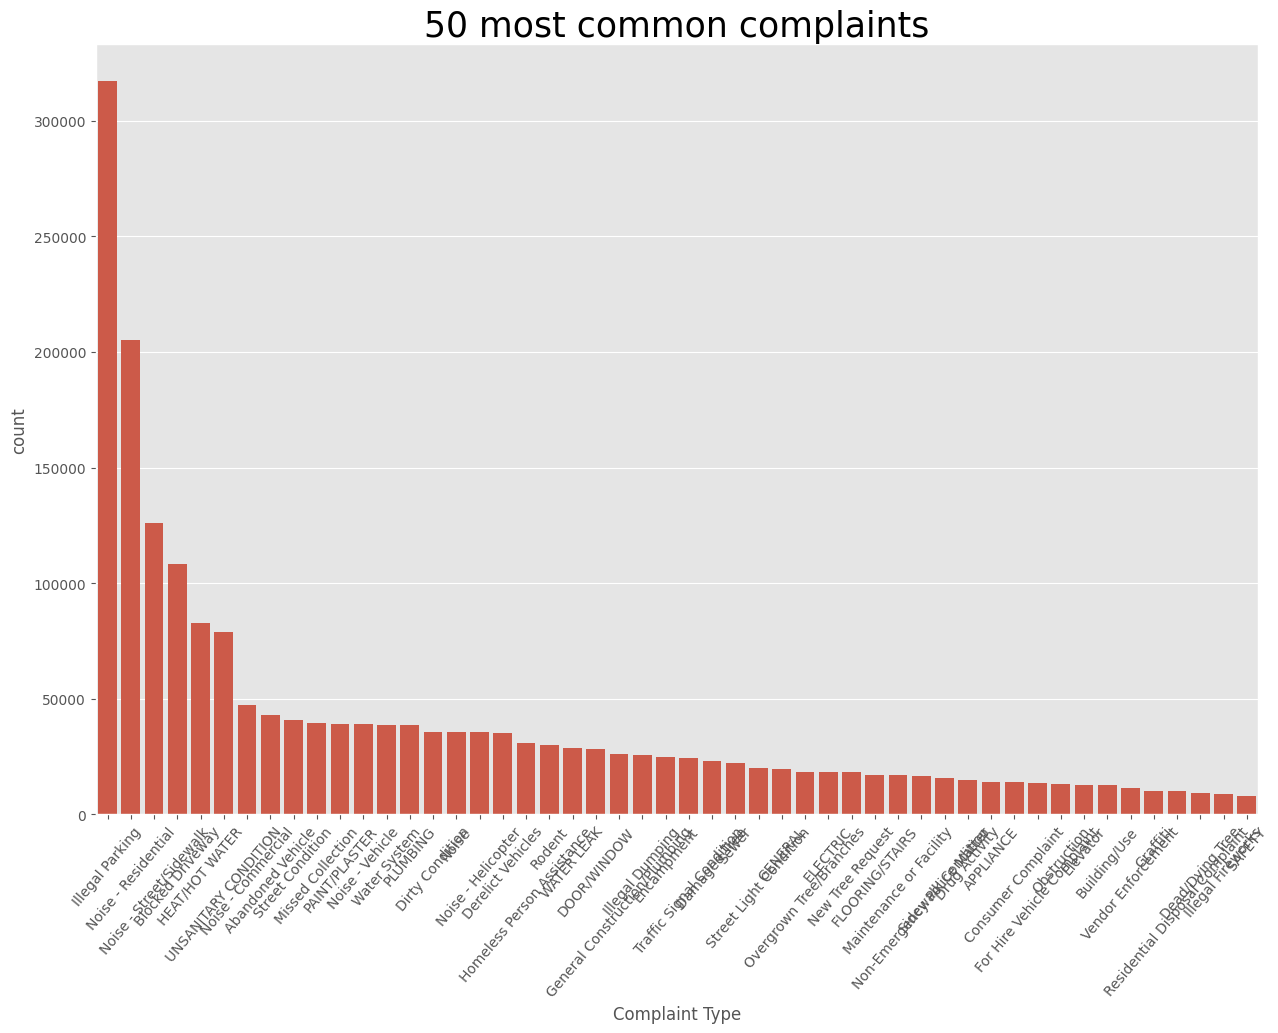

In [16]:
complaints_count = df.group_by('Complaint Type').count().sort('count', descending=True)[:50]
plt.figure(figsize = (15,10))
sns.barplot(data=complaints_count.to_pandas(), x='Complaint Type', y='count')
plt.title('50 most common complaints',fontsize=25)
plt.xticks(rotation = 50)
plt.show()

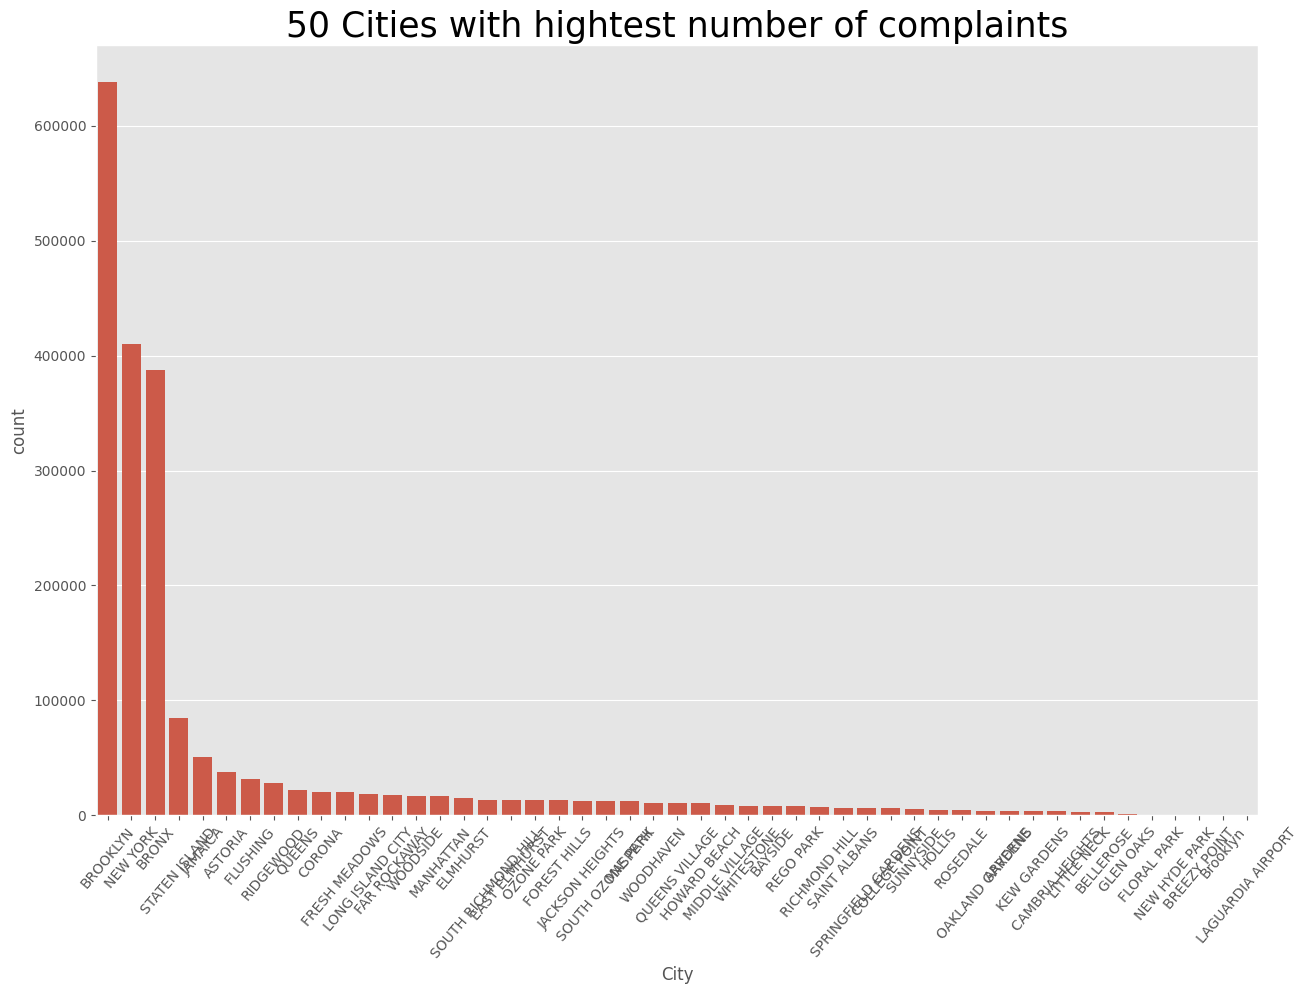

In [27]:
complaints_count = df.group_by('City').count().sort('count', descending=True)[:50]
plt.figure(figsize = (15,10))
sns.barplot(data=complaints_count.to_pandas(), x='City', y='count')
plt.title('50 Cities with hightest number of complaints',fontsize=25)
plt.xticks(rotation = 50)
plt.show()

Observed that Brooklyn has the highest number of complaint

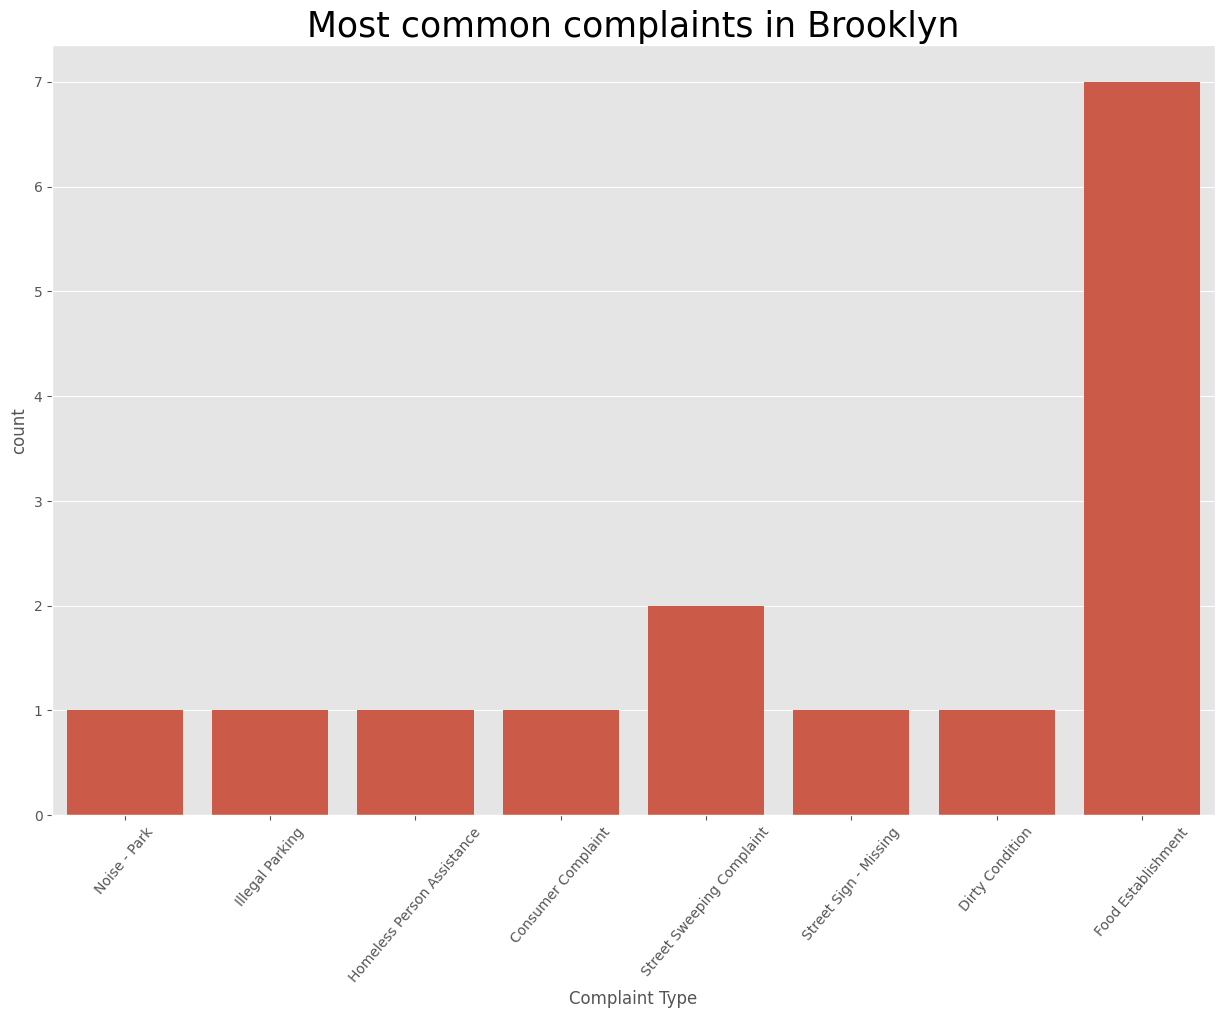

In [31]:
brooklyn_complaint_count = df.filter(pl.col('City') == 'Brooklyn').group_by('Complaint Type').count()
plt.figure(figsize = (15,10))
sns.barplot(data=brooklyn_complaint_count.to_pandas(), x='Complaint Type', y='count')
plt.title('Most common complaints in Brooklyn',fontsize=25)
plt.xticks(rotation = 50)
plt.show()